In [1]:
import json
import os
import random
from argparse import ArgumentParser

import albumentations as A
import annoy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm


def train_val_split(df, fold, seed=42):
    df = df.merge(
        df["artistid"].value_counts(),
        left_on="artistid",
        right_index=True,
        suffixes=[None, "_count"],
    )
    gkf = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=seed)
    for n, (train_ids, val_ids) in enumerate(
        gkf.split(
            X=df[["artistid", "artistid_count"]],
            y=df["artistid_count"],
            groups=df["artistid"],
        )
    ):
        df.loc[val_ids, "fold"] = n
    train_df = df[df["fold"] != fold].reset_index(drop=True).copy()
    val_df = df[df["fold"] == fold].reset_index(drop=True).copy()
    return train_df, val_df


class FeaturesLoader:
    def __init__(
        self, features_dir_path, df, device="cpu", augment=False, crop_size=60
    ):
        self.features_dir_path = features_dir_path
        self.df = df
        self.df["path"] = self.df["archive_features_path"].apply(
            lambda x: os.path.join(features_dir_path, x)
        )
        self.trackid2path = df.set_index("trackid")["path"].to_dict()
        self.crop_size = crop_size
        self.device = device
        self.augment = augment

    def augment_fn(self, img):
        transform = A.Compose(
            [
                A.RandomCrop(always_apply=True, p=1.0, height=512, width=60),
                A.Flip(p=0.2),
                A.PixelDropout(p=0.1, dropout_prob=0.01),
                A.CoarseDropout(
                    p=0.1,
                    max_holes=11,
                    max_height=5,
                    max_width=3,
                    min_holes=1,
                    min_height=2,
                    min_width=2,
                ),
                A.RandomGridShuffle(p=0.3, grid=(1, 6)),
            ]
        )
        return transform(image=img)["image"]

    def _load_item(self, track_id):
        img = np.load(self.trackid2path[track_id])
        if not self.augment:
            padding = (img.shape[1] - self.crop_size) // 2
            img = img[:, padding : padding + self.crop_size]
        else:
            img = self.augment_fn(img)
        return img

    def load_batch(self, tracks_ids):
        batch = [self._load_item(track_id) for track_id in tracks_ids]
        return torch.tensor(np.array(batch)).to(self.device)


class TrainLoader:
    def __init__(self, features_loader, batch_size=256, features_size=(512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        self.artist_track_ids = self.features_loader.df.groupby("artistid").agg(list)

    def _generate_pairs(self, track_ids):
        np.random.shuffle(track_ids)
        pairs = [track_ids[i - 2 : i] for i in range(2, len(track_ids) + 1, 2)]
        return pairs

    def _get_pair_ids(self):
        pairs = []
        artist_track_ids = self.artist_track_ids.copy()
        artist_track_pairs = artist_track_ids["trackid"].map(self._generate_pairs)
        for pair_ids in artist_track_pairs.explode().dropna():
            pairs.append(pair_ids)
        np.random.shuffle(pairs)
        return pairs

    def _get_batch(self, batch_ids):
        batch_ids = np.array(batch_ids).reshape(-1)
        batch_features = self.features_loader.load_batch(batch_ids)
        batch_features = batch_features.reshape(self.batch_size, 2, *self.features_size)
        return batch_features

    def __iter__(self):
        batch_ids = []
        for pair_ids in self._get_pair_ids():
            batch_ids.append(pair_ids)
            if len(batch_ids) == self.batch_size:
                batch = self._get_batch(batch_ids)
                yield batch
                batch_ids = []

    def _len(self):
        return sum(1 for x in self._get_pair_ids()) // self.batch_size


class TestLoader:
    def __init__(self, features_loader, batch_size=256, features_size=(512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size

    def __iter__(self):
        batch_ids = []
        for track_id in tqdm(self.features_loader.df["trackid"].values):
            batch_ids.append(track_id)
            if len(batch_ids) == self.batch_size:
                yield batch_ids, self.features_loader.load_batch(batch_ids)
                batch_ids = []
        if len(batch_ids) > 0:
            yield batch_ids, self.features_loader.load_batch(batch_ids)

In [2]:
def nt_xent_loss(out1, out2, temperature, device):
    out = torch.cat([out1, out2], dim=0)
    n_samples = len(out)

    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    # Negative similarity
    mask = ~torch.eye(n_samples, device=device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity :
    pos = torch.exp(torch.sum(out1 * out2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()

    return loss

In [32]:
!pip install pytorch_metric_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 kB 1.3 MB/s eta 0:00:00a 0:00:01


In [34]:
from pytorch_metric_learning.losses import NTXentLoss

In [35]:
l = NTXentLoss(temperature=0.1)


In [36]:
l(a,a)

ValueError: labels must be a 1D tensor of shape (batch_size,)

In [31]:
nt_xent_loss(a, a, 0.1, 'cpu')

tensor(0.6960, dtype=torch.float64)

In [10]:
a = torch.tensor(np.random.random([4,20]))
b = torch.tensor(np.random.random([4,20]))

In [20]:
out = torch.cat([a, a], dim=0)
n_samples = len(out)
n_samples

8

In [21]:
cov = torch.mm(out, out.t().contiguous())
cov.shape

torch.Size([8, 8])

In [22]:
sim = torch.exp(cov / 0.1)
sim

tensor([[2.8946e+23, 2.1940e+17, 2.2169e+17, 2.7137e+16, 2.8946e+23, 2.1940e+17,
         2.2169e+17, 2.7137e+16],
        [2.1940e+17, 5.1095e+31, 5.6861e+23, 7.5390e+17, 2.1940e+17, 5.1095e+31,
         5.6861e+23, 7.5390e+17],
        [2.2169e+17, 5.6861e+23, 7.4910e+22, 1.4818e+20, 2.2169e+17, 5.6861e+23,
         7.4910e+22, 1.4818e+20],
        [2.7137e+16, 7.5390e+17, 1.4818e+20, 4.9390e+24, 2.7137e+16, 7.5390e+17,
         1.4818e+20, 4.9390e+24],
        [2.8946e+23, 2.1940e+17, 2.2169e+17, 2.7137e+16, 2.8946e+23, 2.1940e+17,
         2.2169e+17, 2.7137e+16],
        [2.1940e+17, 5.1095e+31, 5.6861e+23, 7.5390e+17, 2.1940e+17, 5.1095e+31,
         5.6861e+23, 7.5390e+17],
        [2.2169e+17, 5.6861e+23, 7.4910e+22, 1.4818e+20, 2.2169e+17, 5.6861e+23,
         7.4910e+22, 1.4818e+20],
        [2.7137e+16, 7.5390e+17, 1.4818e+20, 4.9390e+24, 2.7137e+16, 7.5390e+17,
         1.4818e+20, 4.9390e+24]], dtype=torch.float64)

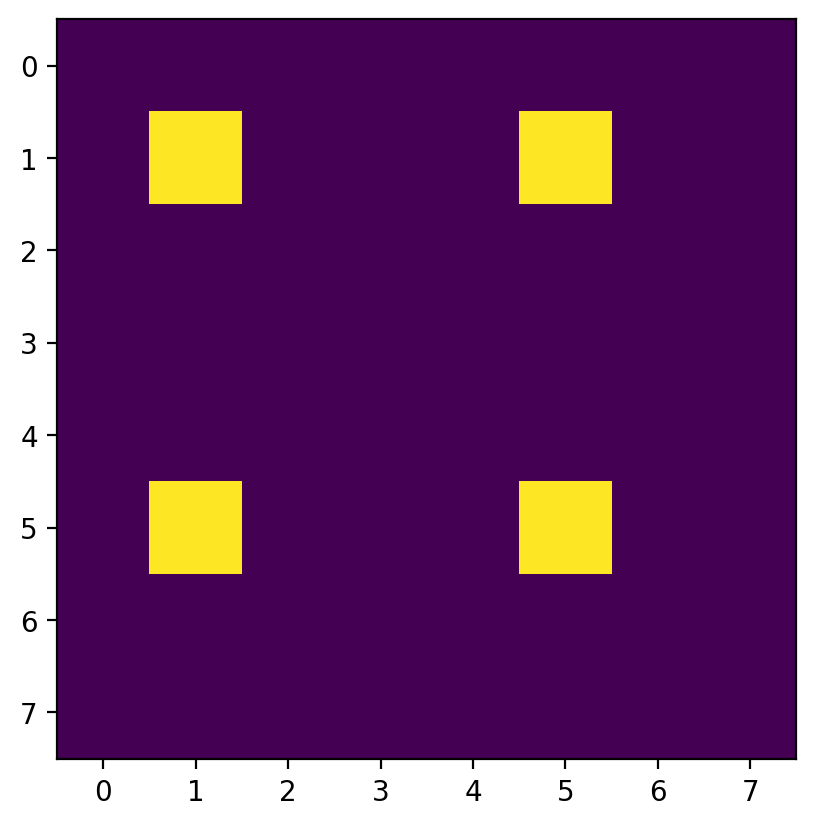

In [23]:
plt.imshow(sim.detach().numpy()/sim.max().numpy())

In [24]:
mask = ~torch.eye(n_samples, device='cpu').bool()

In [25]:
mask

tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True,  True,  True,  True],
        [ True,  True,  True,  True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True, False,  True,  True],
        [ True,  True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True,  True,  True, False]])

In [26]:
neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)
neg

tensor([2.8946e+23, 5.1095e+31, 1.2124e+24, 4.9393e+24, 2.8946e+23, 5.1095e+31,
        1.2124e+24, 4.9393e+24], dtype=torch.float64)

In [29]:
pos = torch.exp(torch.sum(a * a, dim=-1) / 0.1)
pos

tensor([2.8946e+23, 5.1095e+31, 7.4910e+22, 4.9390e+24], dtype=torch.float64)

tensor([[0.7226, 0.8226, 0.1686, 0.0128, 0.4602, 0.0442, 0.8772, 0.4807, 0.0343,
         0.1533, 0.6393, 0.0985, 0.3595, 0.0443, 0.8754, 0.3579, 0.5887, 0.1382,
         0.4748, 0.9491],
        [0.9278, 0.6011, 0.8120, 0.9719, 0.1510, 0.0305, 0.1976, 0.0418, 0.8332,
         0.4206, 0.5747, 0.3835, 0.9328, 0.7024, 0.6640, 0.3037, 0.9474, 0.2863,
         0.4265, 0.0634],
        [0.7741, 0.5426, 0.6547, 0.2739, 0.3012, 0.0467, 0.3211, 0.2559, 0.9328,
         0.2122, 0.2149, 0.4281, 0.7463, 0.2176, 0.5906, 0.1065, 0.5939, 0.3515,
         0.9081, 0.4453],
        [0.6371, 0.0719, 0.4750, 0.0307, 0.2077, 0.3757, 0.5899, 0.9960, 0.8472,
         0.2983, 0.1232, 0.6274, 0.6610, 0.2617, 0.1144, 0.1047, 0.2864, 0.4276,
         0.8551, 0.8848]], dtype=torch.float64)

In [4]:
root_dir = "/app/_data/artist_data/"
train = pd.read_csv(os.path.join(root_dir, "train_meta.tsv"), sep="\t")
test = pd.read_csv(os.path.join(root_dir, "test_meta.tsv"), sep="\t")

fl = FeaturesLoader(
    features_dir_path="/app/_data/artist_data/train_features",
    df=train,
    device="cpu",
    augment=True,
    crop_size=60,
)

tl = TrainLoader(features_loader=fl, batch_size=256, features_size=(512, 60))

for i, x in enumerate(tl):
    if i == 2:
        break

x.shape

In [11]:
class BaseModel(nn.Module):
    def __init__(
        self,
        output_features_size1=512,
        output_features_size2=128,
        embed_len=128,
        kernel_size=3,
    ):
        super().__init__()
        self.output_features_size = output_features_size1 + output_features_size2
        self.embed_len = embed_len
        self.conv_1 = nn.Conv1d(
            512, output_features_size1, kernel_size=kernel_size, padding=1
        )
        self.conv_2 = nn.Conv1d(
            output_features_size1,
            output_features_size1,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1 = nn.MaxPool1d(2)
        self.conv_1_2 = nn.Conv1d(
            60, output_features_size2, kernel_size=kernel_size, padding=1
        )
        self.conv_2_2 = nn.Conv1d(
            output_features_size2,
            output_features_size2,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1_2 = nn.MaxPool1d(2)
        self.linear = nn.Sequential(
            nn.Linear(self.output_features_size, self.output_features_size, bias=False),
            nn.ReLU(),
            nn.Linear(self.output_features_size, self.embed_len, bias=False),
        )

    def forward(self, x):
        y = x.transpose(2, 1)
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x).mean(axis=2)

        y = F.relu(self.conv_1_2(y))
        y = F.relu(self.conv_2_2(y))
        y = self.mp_1_2(y).mean(axis=2)
        output = torch.cat([x, y], axis=-1)
        output = self.linear(output)

        return output

In [12]:
model = BaseModel(
        output_features_size1=512,
        output_features_size2=128,
        embed_len=256,
        kernel_size=3,
    )

In [13]:
weights = torch.load('/app/_data/artist_data/models/exp1/best.pt')

In [14]:
model.to('cuda')

BaseModel(
  (conv_1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (mp_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1_2): Conv1d(60, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv_2_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (mp_1_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Sequential(
    (0): Linear(in_features=640, out_features=640, bias=False)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=256, bias=False)
  )
)

In [15]:
model.load_state_dict(weights)

<All keys matched successfully>

In [4]:
class Custom_Loss(nn.Module):
    def __init__(self, temperature):
        super(Custom_Loss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_fn = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, y_i, y_j):
        batch_size = y_i.shape[0]
        N = 2 * batch_size
        z = torch.cat((y_i, y_j), dim=0)
        sim = self.similarity_fn(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        mask = self.mask_correlated_samples(batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        labels[0] = 1
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss


def get_ranked_list(embeds, top_size=100, annoy_num_trees=128):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in tqdm(embeds.items()):
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), "angular")
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees, n_jobs=-1)
    ranked_list = dict()
    for track_id in tqdm(embeds.keys()):
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size + 1)[1:]
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list


def position_discounter(position):
    return 1.0 / np.log2(position + 1)


def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg


def compute_dcg(query_trackid, ranked_list, track2artist, top_size):
    query_artistid = track2artist[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list[:top_size]):
        assert result_trackid != query_trackid
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg


def eval_submission(submission, df, top_size=100):
    track2artist = df.set_index("trackid")["artistid"].to_dict()
    artist2tracks = df.groupby("artistid").agg(list)["trackid"].to_dict()
    ndcg_list = []
    for query_trackid in tqdm(submission.keys()):
        ranked_list = submission[query_trackid]
        query_artistid = track2artist[query_trackid]
        query_artist_tracks_count = len(artist2tracks[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count - 1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist, top_size=top_size)
        try:
            ndcg_list.append(dcg / ideal_dcg)
        except ZeroDivisionError:
            continue
    return np.mean(ndcg_list)


class BaseModel(nn.Module):
    def __init__(
        self,
        output_features_size1=512,
        output_features_size2=128,
        embed_len=128,
        kernel_size=3,
    ):
        super().__init__()
        self.output_features_size = output_features_size1 + output_features_size2
        self.embed_len = embed_len
        self.conv_1 = nn.Conv1d(
            512, output_features_size1, kernel_size=kernel_size, padding=1
        )
        self.conv_2 = nn.Conv1d(
            output_features_size1,
            output_features_size1,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1 = nn.MaxPool1d(2)
        self.conv_1_2 = nn.Conv1d(
            60, output_features_size2, kernel_size=kernel_size, padding=1
        )
        self.conv_2_2 = nn.Conv1d(
            output_features_size2,
            output_features_size2,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1_2 = nn.MaxPool1d(2)
        self.linear = nn.Sequential(
            nn.Linear(self.output_features_size, self.output_features_size, bias=False),
            nn.ReLU(),
            nn.Linear(self.output_features_size, self.embed_len, bias=False),
        )

    def forward(self, x):
        y = x.transpose(2, 1)
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x).mean(axis=2)

        y = F.relu(self.conv_1_2(y))
        y = F.relu(self.conv_2_2(y))
        y = self.mp_1_2(y).mean(axis=2)
        output = torch.cat([x, y], axis=-1)
        output = self.linear(output)

        return output


def inference(model, loader):
    embeds = dict()
    model.eval()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds


class EarlyStopper:
    def __init__(self, patience=5, min_delta=1e-6):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_metric = 0

    def early_stop(self, validation_metric):
        if validation_metric > self.min_validation_metric:
            self.min_validation_metric = validation_metric
            self.counter = 0
        elif validation_metric < (self.min_validation_metric + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(
    model,
    train_loader,
    val_loader,
    val_df,
    optimizer,
    criterion,
    num_epochs,
    model_path,
    history_path,
    top_size=100,
    sceduler_patience=4,
    early_stopping_patience=13,
):
    max_ndcg = None
    best_epoch = 0
    metrics = {"train_loss": [], "ndcg": []}
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=sceduler_patience, verbose=True
    )
    early_stopper = EarlyStopper(patience=early_stopping_patience)
    for epoch in range(num_epochs):
        train_bar = tqdm(
            enumerate(train_loader),
            total=train_loader._len(),
            desc=f"Train: epoch #{epoch + 1}/{num_epochs}",
        )
        running_loss = 0
        epoch_loss = 0
        for n, batch in train_bar:
            optimizer.zero_grad()
            model.train()
            x_i, x_j = batch[:, 0, :, :], batch[:, 1, :, :]
            y_i = model(x_i)
            y_j = model(x_j)
            loss = criterion(y_i, y_j)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss = running_loss / (n + 1)
            current_lr = optimizer.param_groups[0]["lr"]
            memory = (
                torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
            )
            train_bar.set_postfix(
                train_loss=f"{epoch_loss:0.4f}",
                lr=f"{current_lr:0.6f}",
                gpu_memory=f"{memory:0.2f} GB",
            )
        metrics["train_loss"].append(epoch_loss)

        with torch.no_grad():
            print("\nValidation nDCG on epoch {}".format(epoch + 1))
            embeds = inference(model, val_loader)
            ranked_list = get_ranked_list(embeds, top_size, 128)
            val_ndcg = eval_submission(ranked_list, val_df)
            metrics["ndcg"].append(val_ndcg)
            print(f"ndcg = {val_ndcg} at {epoch + 1} epoch")
            if (max_ndcg is None) or (val_ndcg > max_ndcg):
                print(
                    f"ndcg improved from {max_ndcg} to {val_ndcg}, checkpoints saved to {model_path}"
                )
                max_ndcg = val_ndcg
                best_epoch = epoch
                torch.save(model.state_dict(), model_path)

            scheduler.step(val_ndcg)
            if early_stopper.early_stop(val_ndcg):
                break
    with open(os.path.join(history_path, "history.json"), "w") as f:
        json.dump(metrics, f)
    print(f"Best ndcg = {max_ndcg} at {best_epoch} epoch\n")


def save_submission(submission, submission_path, top=100):
    with open(submission_path, "w") as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result[:top]))))



def main():
    parser = ArgumentParser(description="Simple naive baseline")
    parser.add_argument(
        "--base-dir",
        dest="base_dir",
        action="store",
        required=False,
        type=str,
        nargs="?",
        const="/app/_data/artist_data/",
        default="/app/_data/artist_data/",
    )
    parser.add_argument(
        "--save-dir", dest="save_dir", action="store", required=True, type=str
    )
    parser.add_argument(
        "--fold",
        dest="fold",
        action="store",
        required=False,
        nargs="?",
        const=0,
        type=int,
        default=0,
    )
    parser.add_argument(
        "--batch-size",
        dest="batch_size",
        action="store",
        required=False,
        nargs="?",
        const=512,
        type=int,
        default=512,
    )
    parser.add_argument(
        "--n-channels",
        dest="n_channels",
        action="store",
        required=False,
        nargs="?",
        const=256,
        type=int,
        default=256,
    )
    parser.add_argument(
        "--emb-len",
        dest="emb_len",
        action="store",
        required=False,
        nargs="?",
        const=128,
        type=int,
        default=128,
    )
    parser.add_argument(
        "--kernel-size",
        dest="kernel_size",
        action="store",
        required=False,
        nargs="?",
        const=3,
        type=int,
        default=3,
    )
    parser.add_argument(
        "--n-epochs",
        dest="n_epochs",
        action="store",
        required=False,
        nargs="?",
        const=150,
        type=int,
        default=150,
    )
    parser.add_argument(
        "--temperature",
        dest="temperature",
        action="store",
        required=False,
        nargs="?",
        const=0.01,
        type=float,
        default=0.01,
    )
    parser.add_argument(
        "--stopping-patience",
        dest="early_stopping_patience",
        action="store",
        required=False,
        nargs="?",
        const=13,
        type=int,
        default=13,
    )
    parser.add_argument(
        "--sceduler-patience",
        dest="sceduler_patience",
        action="store",
        required=False,
        nargs="?",
        const=13,
        type=int,
        default=13,
    )
    args = parser.parse_args()

    # python3 train_main.py --base-dir='/app/_data/artist_data/' --save-dir='ny_2_1' --fold=1 --batch-size=512 --n-channels=512 --emb-len=256 --n-epochs=150 --kernel-size=3 --temperature=0.01
    # Seed
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    BATCH_SIZE = args.batch_size
    N_OUTPUT_CHANNELS = args.n_channels
    EMBEDDING_LEN = args.emb_len
    KERNEL_SIZE = args.kernel_size
    NUM_EPOCHS = args.n_epochs
    FOLD = args.fold
    LR = 1e-4
    TEMPERATURE = args.temperature
    SCEDULER_PATIENCE = args.sceduler_patience
    STOPPING_PATIENCE = args.early_stopping_patience

    TRAINSET_PATH = os.path.join(args.base_dir, "train_features")
    TESTSET_PATH = os.path.join(args.base_dir, "test_features")
    TRAINSET_META_PATH = os.path.join(args.base_dir, "train_meta.tsv")
    TESTSET_META_PATH = os.path.join(args.base_dir, "test_meta.tsv")
    BASE_DIR = os.path.join(args.base_dir, "models", args.save_dir)
    SUBMISSION_PATH = os.path.join(BASE_DIR, "submission.txt")
    CHECKPOINT_PATH = os.path.join(BASE_DIR, "best.pt")

    if not os.path.exists(BASE_DIR):
        os.makedirs(BASE_DIR)

    with open(
        os.path.join(args.base_dir, "models", args.save_dir, "args.json"), "w"
    ) as f:
        json.dump(args.__dict__, f)

    model = BaseModel(N_CHANNELS, 128, EMBEDDING_LEN).to(DEVICE)

    train = pd.read_csv(TRAINSET_META_PATH, sep="\t")
    test_df = pd.read_csv(TESTSET_META_PATH, sep="\t")
    train_df, val_df = train_val_split(train, fold=FOLD, seed=seed)

    print("Loaded data")
    print("Train set size: {}".format(len(train_df)))
    print("Validation set size: {}".format(len(val_df)))
    print("Test set size: {}".format(len(test_df)))
    print()
    print("Train")
    train(
        model=model,
        train_loader=TrainLoader(
            FeaturesLoader(
                features_dir_path=TRAINSET_PATH,
                meta_info=train_meta_info,
                device=DEVICE,
                augment=True,
            ),
            batch_size=BATCH_SIZE,
        ),
        val_loader=TestLoader(
            FeaturesLoader(
                features_dir_path=TRAINSET_PATH,
                meta_info=validation_meta_info,
                device=DEVICE,
                augment=False,
            ),
            batch_size=BATCH_SIZE,
        ),
        valset_meta=validation_meta_info,
        optimizer=torch.optim.Adam(sim_clr.parameters(), lr=LR),
        criterion=Custom_Loss(temperature=TEMPERATURE),
        num_epochs=NUM_EPOCHS,
        model_path=CHECKPOINT_PATH,
        history_path=BASE_DIR,
        sceduler_patience=SCEDULER_PATIENCE,
        early_stopping_patience=args.early_stopping_patience,
    )

    print("\nSubmission")
    test_loader = TestLoader(
        FeaturesLoader(
            features_dir_path=TESTSET_PATH,
            meta_info=test_meta_info,
            device=DEVICE,
            augment=False,
        ),
        batch_size=BATCH_SIZE,
    )
    model.load_state_dict(torch.load(CHECKPOINT_PATH)).to(DEVICE)
    model.eval()
    embeds = inference(model, test_loader)
    submission = get_ranked_list(embeds=embeds, top_size=500, annoy_num_trees=1024)
    save_submission(submission, os.path.join(BASE_DIR, "submission_100.txt"), top=100)
    save_submission(submission, os.path.join(BASE_DIR, "submission_500.txt"), top=500)


if __name__ == "__main__":
    main()